In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [29]:
from preprocess import divide_to_train_and_test, one_hot
from confusion_matrix import print_confusion_matrix

In [68]:
def load_from_directory(texts_directory, images_directory, target_names, max_files_in_one_category=30000):
    file_texts = []
    targets = []
    
    for root, dirs, files in os.walk(images_directory):
        number_used_files = 0
        print(root)
        for name in files:
            if number_used_files < max_files_in_one_category:
            
                name_without_extenstion, _ = os.path.splitext(name)
                
                _, cur_target = os.path.split(root)
                cur_target = target_names.index(cur_target)
            
                text_name = name_without_extenstion + ".txt"
                cur_text_path =  os.path.join(texts_directory, text_name)
                
                with open(cur_text_path, encoding="utf-16") as file:
                    try:
                        # считываем файл построчно
                        file_text = ""
                        for line in file.readlines():
                            file_text += (line)
                        if file_text != "" and file_text != " ":
                            file_texts.append(file_text[2:])
                            targets.append(cur_target)
                        else:
                            print(cur_text_path)
                
                            number_used_files += 1            
                    except:
                        print("PROBLEM WITH FILE", cur_text_path)
        print("")
                
    return file_texts, targets


In [69]:
CATEGORIES_COUNT = 11

In [70]:
%%time
file_texts, targets = load_from_directory(texts_directory="D:/svruchtel/DATA/USA_New/Texts",
                                         images_directory="D:/svruchtel/DATA/USA_New/Images_Unite", 
                                         target_names = ["Airfare", "CarRental", "Fuel", "GeneralRetail", "Hotel",
                                                         "Other", "Parking", "Restaurant", "Taxi", "Toll", "Transport"])

D:/svruchtel/DATA/USA_New/Images_Unite

D:/svruchtel/DATA/USA_New/Images_Unite\Airfare

D:/svruchtel/DATA/USA_New/Images_Unite\CarRental
D:/svruchtel/DATA/USA_New/Texts\000429.txt
D:/svruchtel/DATA/USA_New/Texts\000448.txt
D:/svruchtel/DATA/USA_New/Texts\000454.txt

D:/svruchtel/DATA/USA_New/Images_Unite\Fuel

D:/svruchtel/DATA/USA_New/Images_Unite\GeneralRetail
D:/svruchtel/DATA/USA_New/Texts\000676.txt
D:/svruchtel/DATA/USA_New/Texts\000677.txt
D:/svruchtel/DATA/USA_New/Texts\000679.txt
D:/svruchtel/DATA/USA_New/Texts\000683.txt
D:/svruchtel/DATA/USA_New/Texts\000702.txt
D:/svruchtel/DATA/USA_New/Texts\000722.txt
D:/svruchtel/DATA/USA_New/Texts\000743.txt

D:/svruchtel/DATA/USA_New/Images_Unite\Hotel
D:/svruchtel/DATA/USA_New/Texts\003471.txt

D:/svruchtel/DATA/USA_New/Images_Unite\Other
D:/svruchtel/DATA/USA_New/Texts\003823.txt
D:/svruchtel/DATA/USA_New/Texts\003834.txt
D:/svruchtel/DATA/USA_New/Texts\003932.txt
D:/svruchtel/DATA/USA_New/Texts\003955.txt
D:/svruchtel/DATA/USA_New/T

In [59]:
len(file_texts)

6153

In [7]:
text_1 = file_texts[0]
print(text_1)

Expedia*
Receipt for Beirut
Aug 10, 2017 - Aug 28, 2017 Itinerary # 7285684220348
Booked Items Cost Summary
Booked Date: Aug 4, 2017
Flight: Cincinnati (CVG) to Beirut (BEY) �ler 1: $2,374.96
Adult
Depart: 8/10/2017 | Return: 8/28/2017 ,1 round trip ticket m y� qq
, i r i- Taxes & $624.96
Traveler I nformation Fees
Expedia $10.00
BAHIGE ELRAYES-Adult Booking
Fee
Ticket # 0578643753685
Total: $2,384.96
Paid: $2,384.96
[AmericanExpress 2002]
All prices quoted in US
dollars.



In [8]:
#print(list(text_1))

text_new = [char for char in list(text_1) if (char != ' ' and char != '\n')]
print(text_new)


['E', 'x', 'p', 'e', 'd', 'i', 'a', '*', 'R', 'e', 'c', 'e', 'i', 'p', 't', 'f', 'o', 'r', 'B', 'e', 'i', 'r', 'u', 't', 'A', 'u', 'g', '1', '0', ',', '2', '0', '1', '7', '-', 'A', 'u', 'g', '2', '8', ',', '2', '0', '1', '7', 'I', 't', 'i', 'n', 'e', 'r', 'a', 'r', 'y', '#', '7', '2', '8', '5', '6', '8', '4', '2', '2', '0', '3', '4', '8', 'B', 'o', 'o', 'k', 'e', 'd', 'I', 't', 'e', 'm', 's', 'C', 'o', 's', 't', 'S', 'u', 'm', 'm', 'a', 'r', 'y', 'B', 'o', 'o', 'k', 'e', 'd', 'D', 'a', 't', 'e', ':', 'A', 'u', 'g', '4', ',', '2', '0', '1', '7', 'F', 'l', 'i', 'g', 'h', 't', ':', 'C', 'i', 'n', 'c', 'i', 'n', 'n', 'a', 't', 'i', '(', 'C', 'V', 'G', ')', 't', 'o', 'B', 'e', 'i', 'r', 'u', 't', '(', 'B', 'E', 'Y', ')', '�', 'l', 'e', 'r', '1', ':', '$', '2', ',', '3', '7', '4', '.', '9', '6', 'A', 'd', 'u', 'l', 't', 'D', 'e', 'p', 'a', 'r', 't', ':', '8', '/', '1', '0', '/', '2', '0', '1', '7', '|', 'R', 'e', 't', 'u', 'r', 'n', ':', '8', '/', '2', '8', '/', '2', '0', '1', '7', ',', '1',

In [9]:
#let's try to write another version of "load_embeddins"

def load_embeddings(emb_path, max_embeddings_count=100000):
    emb_word_id_to_vector = {}
    word_to_id = {}
    current_word_id = 0
    with open(emb_path, 'r', encoding='utf-8') as f:
        for line in f:
            if current_word_id <= max_embeddings_count:
                line_split = line.strip().split(" ")
                word = line_split[0]
                word_emb = np.array(line_split[1:], dtype=float)
            
                if word_emb.shape != (300,):
                    print("ERROR! Shape is", word_emb.shape, word)
                    continue
            
                word_to_id[word] = current_word_id
                emb_word_id_to_vector[current_word_id] = word_emb
                current_word_id += 1
            else:
                break
            
    return emb_word_id_to_vector, word_to_id

In [10]:
%%time
emb_char_id_to_vector, char_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/wiki.en.-char.vec", 
                                    max_embeddings_count=300000)

Wall time: 67.8 ms


In [13]:
print(emb_char_id_to_vector[0][:7])
print(emb_char_id_to_vector[1][:7])

[-0.168196 -0.078583 -0.143239  0.15997  -0.062997 -0.31179   0.223555]
[-0.399402  0.019168 -0.162129  0.337873 -0.073754 -0.34943   0.447316]


In [14]:
print(len(emb_char_id_to_vector))

52


In [17]:
char_to_id['-']

42

In [41]:
def change_texts_to_lists_of_character_embeddings(X, emb_char_id_to_vector, char_to_id, characters_count=3000):
    """
    X - list of strings (original texts)
    """
    
    X_emb = []
    for text in X:
        text_chars = [char for char in list(text) if (char != ' ' and char != '\n')]
        
        embedded_text = []
        current_chars_count = 0
        
        for char in text_chars:
            if current_chars_count < characters_count:
                if char in char_to_id:
                    embedded_text.append(emb_char_id_to_vector[char_to_id[char]])
                    current_chars_count += 1
                elif char.lower() in char_to_id:
                    embedded_text.append(emb_char_id_to_vector[char_to_id[char.lower()]])
                    current_chars_count += 1
                #else:
                    #print("There is no embedding to char:", char)
        
        # if text is less long than need to be
        while current_chars_count < characters_count:
            #embedded_text.append(emb_char_id_to_vector[char_to_id['-']])
            embedded_text.append(emb_char_id_to_vector[char_to_id['0']])
            current_chars_count += 1    
        
        X_emb.append(np.array(embedded_text))
        
    return np.array(X_emb)

In [22]:
%%time
X_emb = change_texts_to_lists_of_character_embeddings(file_texts, emb_char_id_to_vector, char_to_id, characters_count=100)

Wall time: 7.04 s


In [23]:
char_to_id['f']

18

In [24]:
X_emb_train, targets_train, X_emb_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=CATEGORIES_COUNT)

y_train = one_hot(targets_train, classes_count=CATEGORIES_COUNT)
y_test = one_hot(targets_test, classes_count=CATEGORIES_COUNT)

In [25]:
print(X_emb_train.shape)
print(X_emb_test.shape)
print(y_train.shape)
print(y_test.shape)

(5531, 100, 300)
(622, 100, 300)
(5531, 11)
(622, 11)


### 3

In [27]:
%%time
# and another

# with recurrent droupout
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1111      
Total params: 161,511
Trainable params: 161,511
Non-trainable params: 0
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/200
5531/5531 [==============================] - 39s 7ms/step - loss: 1.8000 - acc: 0.4495 - val_loss: 1.7688 - val_acc: 0.4405
Epoch 2/200
5531/5531 [==============================] - 36s 6ms/step - loss: 1.7305 - acc: 0.4652 - val_loss: 1.7595 - val_acc: 0.4453
Epoch 3/200
5531/5531 [==============================] - 35s 6ms/step - loss: 1.6381 - acc: 0.4838 - val_loss: 1.6114 - val_acc: 0.4775
Epoch 4/200
5531/5531 [==============================] - 35s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 259    2    0    3   23   37    0   15   23    0    0]
 [   2   88    0    0    9   19    1   15    8    0    0]
 [   0    0   28    0    5    6    1   16    4    5    0]
 [   3    4    0   44   24   45    1  116   36    0    1]
 [   7    2    0    1 2355   42    1   65   19    0    1]
 [   7    5    2    4   54  368    1   76   63    2    1]
 [   1    1    0    0   27   11   40   21    8    0    0]
 [   3    9    1   13   48   57    5  556   40    5    1]
 [   0    1    1    1   18   49    1   24  525   10    0]
 [   0    0    0    0    0    3    0    3    5   25    0]
 [  12    4    1    1    9   27    0   10   17    4   14]]
Normalized confusion matrix
[[7.15469613e-01 5.52486188e-03 0.00000000e+00 8.28729282e-03
  6.35359116e-02 1.02209945e-01 0.00000000e+00 4.14364641e-02
  6.35359116e-02 0.00000000e+00 0.00000000e+00]
 [1.40845070e-02 6.19718310e-01 0.00000000e+00 0.00000000e+00
  6.33802817e-02 1.33802817e-01 7.04

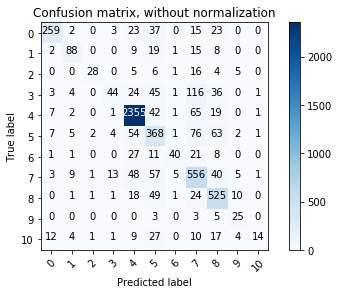

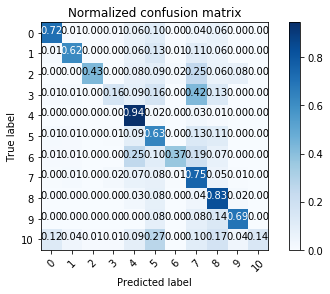

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 32   0   0   0   5   2   0   0   2   0   0]
 [  0   1   0   0   7   4   0   0   4   0   0]
 [  0   0   3   0   0   0   0   4   1   0   0]
 [  0   0   0   0   2   7   0  16   6   0   0]
 [  0   0   0   4 227  14   1  24   8   0   0]
 [  1   0   1   0   3  21   0  30   9   0   0]
 [  0   0   0   0   3   1   4   5   0   0   0]
 [  0   0   0   1   4   9   1  59   9   0   0]
 [  2   0   0   4   4  17   0  12  31   1   0]
 [  0   0   0   0   0   1   1   0   1   1   0]
 [  0   0   1   0   2   4   1   3   1   0   0]]
Normalized confusion matrix
[[0.7804878  0.         0.         0.         0.12195122 0.04878049
  0.         0.         0.04878049 0.         0.        ]
 [0.         0.0625     0.         0.         0.4375     0.25
  0.         0.         0.25       0.         0.        ]
 [0.         0.         0.375      0.         0.         0.
  0.         0.5        0.125      0.         0.        ]
 [0.         0.         0.  

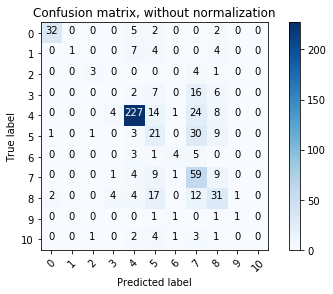

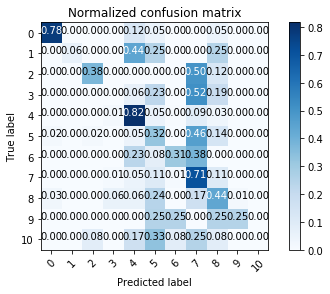

In [30]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [31]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.6093


In [33]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/USA_3rd_net_train_X_100_chars_WIKI.EN.npy"
file_path_test_X = "./LSTM_results_char_emb/USA_3rd_net_test_X_100_chars_WIKI.EN.npy"

#file_path_train_y = "./LSTM_results_char_emb/France_ByShape_1st_net_train_y.npy"
#file_path_test_y = "./LSTM_results_char_emb/France_ByShape_1st_net_test_y.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)
#np.save(file_path_train_y, y_train)
#np.save(file_path_test_y, y_test)

Wall time: 29.7 s


## GLOVE_EN_CHAR

In [36]:
%%time
emb_char_id_to_vector, char_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/glove.840B.300d/glove.840B.300d-char.txt", 
                                    max_embeddings_count=300000)

Wall time: 65.3 ms


In [37]:
print(emb_char_id_to_vector[0][:7])
print(emb_char_id_to_vector[1][:7])

[ 0.28033  -0.500771 -0.162017  0.021303 -0.097933  0.252948  0.222009]
[ 0.251953 -0.285331  0.103711  0.003187 -0.068849  0.094527  0.073448]


In [38]:
print(len(emb_char_id_to_vector))

94


In [40]:
char_to_id['-']

37

In [42]:
%%time
X_emb = change_texts_to_lists_of_character_embeddings(file_texts, emb_char_id_to_vector, char_to_id, characters_count=100)

Wall time: 6.51 s


In [43]:
X_emb_train, targets_train, X_emb_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=CATEGORIES_COUNT)

y_train = one_hot(targets_train, classes_count=CATEGORIES_COUNT)
y_test = one_hot(targets_test, classes_count=CATEGORIES_COUNT)

In [44]:
print(X_emb_train.shape)
print(X_emb_test.shape)
print(y_train.shape)
print(y_test.shape)

(5531, 100, 300)
(622, 100, 300)
(5531, 11)
(622, 11)


In [45]:
%%time
# and another

# with recurrent droupout
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1111      
Total params: 161,511
Trainable params: 161,511
Non-trainable params: 0
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/200
5531/5531 [==============================] - 40s 7ms/step - loss: 1.7498 - acc: 0.4444 - val_loss: 1.7682 - val_acc: 0.3987
Epoch 2/200
5531/5531 [==============================] - 37s 7ms/step - loss: 1.5640 - acc: 0.4811 - val_loss: 1.6263 - val_acc: 0.4469
Epoch 3/200
5531/5531 [==============================] - 36s 6ms/step - loss: 1.4727 - acc: 0.5160 - val_loss: 1.6786 - val_acc: 0.4502
Epoch 4/200
5531/5531 [==============================] - 36s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 287   10    0    1    5   35    1   14    9    0    0]
 [   3  111    1    1    7    9    1    4    5    0    0]
 [   1    1   42    2    3    3    1    9    2    1    0]
 [   1    2    1  138   19   37    3   61   12    0    0]
 [   3    0    1   11 2400   32    1   27   17    0    1]
 [   1    5    1    7   34  456    2   45   27    4    1]
 [   1    0    0    1   15    9   42   37    3    1    0]
 [   0    3    1   12   23   35    7  638   19    0    0]
 [   0    0    1    0    6   51    2   27  538    5    0]
 [   0    1    0    0    0    0    1    2    7   24    1]
 [   9    5    0    2    6   26    0   12    8    0   31]]
Normalized confusion matrix
[[7.92817680e-01 2.76243094e-02 0.00000000e+00 2.76243094e-03
  1.38121547e-02 9.66850829e-02 2.76243094e-03 3.86740331e-02
  2.48618785e-02 0.00000000e+00 0.00000000e+00]
 [2.11267606e-02 7.81690141e-01 7.04225352e-03 7.04225352e-03
  4.92957746e-02 6.33802817e-02 7.04

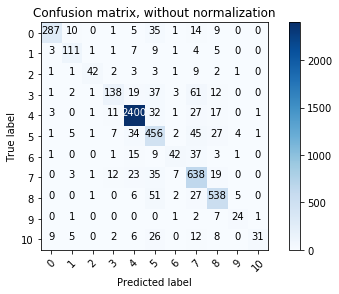

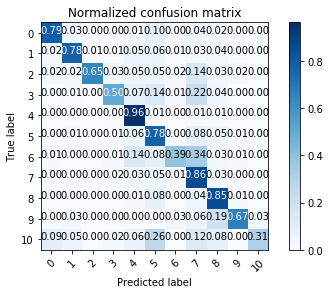

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 33   0   0   0   0   3   0   3   2   0   0]
 [  0   3   1   1   5   4   0   0   0   1   1]
 [  0   0   1   2   0   0   0   4   1   0   0]
 [  0   1   0   8   1   2   0  15   4   0   0]
 [  0   1   0   7 229  16   3  20   2   0   0]
 [  2   0   1   3   2  34   1  18   4   0   0]
 [  0   0   0   0   2   2   1   6   2   0   0]
 [  0   1   0   2   5   3   0  71   1   0   0]
 [  0   0   0   1   2  15   0  13  38   2   0]
 [  0   0   0   0   0   1   0   1   1   1   0]
 [  1   0   1   0   1   1   0   6   2   0   0]]
Normalized confusion matrix
[[0.80487805 0.         0.         0.         0.         0.07317073
  0.         0.07317073 0.04878049 0.         0.        ]
 [0.         0.1875     0.0625     0.0625     0.3125     0.25
  0.         0.         0.         0.0625     0.0625    ]
 [0.         0.         0.125      0.25       0.         0.
  0.         0.5        0.125      0.         0.        ]
 [0.         0.03225806 0.  

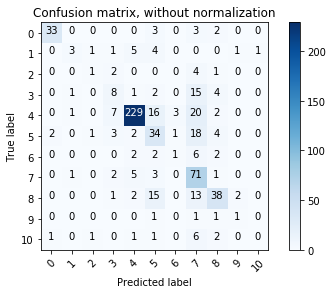

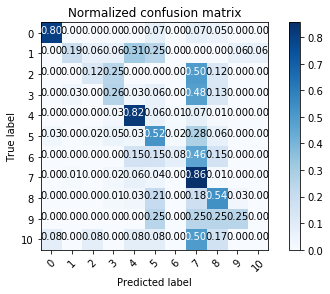

In [46]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [47]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.6736


In [48]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/USA_3rd_net_train_X_100_chars_GLOVE.EN.npy"
file_path_test_X = "./LSTM_results_char_emb/USA_3rd_net_test_X_100_chars_GLOVE.EN.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)

Wall time: 30.4 s


## CHAR_GLOVE_FR

In [49]:
%%time
emb_char_id_to_vector, char_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/glove.840B.300d/glove.840B.300d-char-fr.txt", 
                                    max_embeddings_count=300000)

ERROR! Shape is (299,) 0.37558
Wall time: 60.1 ms


In [50]:
print(len(emb_char_id_to_vector))

194


In [51]:
%%time
X_emb = change_texts_to_lists_of_character_embeddings(file_texts, emb_char_id_to_vector, char_to_id, characters_count=100)

X_emb_train, targets_train, X_emb_test, targets_test = divide_to_train_and_test(X_emb, targets, num_categories=CATEGORIES_COUNT)

Wall time: 10.2 s


In [52]:
print(X_emb_train.shape)
print(X_emb_test.shape)
print(y_train.shape)
print(y_test.shape)

(5531, 100, 300)
(622, 100, 300)
(5531, 11)
(622, 11)


In [53]:
%%time
# and another

# with recurrent droupout
categories_count = CATEGORIES_COUNT

model = Sequential()
model.add(LSTM(100, input_shape=X_emb_train[0].shape, recurrent_dropout=0.2))
model.add(Dense(categories_count, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_emb_train, y_train, validation_data=(X_emb_test, y_test),
                    epochs=200, batch_size=100, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_emb_test, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 11)                1111      
Total params: 161,511
Trainable params: 161,511
Non-trainable params: 0
_________________________________________________________________
None
Train on 5531 samples, validate on 622 samples
Epoch 1/200
5531/5531 [==============================] - 39s 7ms/step - loss: 1.7292 - acc: 0.4498 - val_loss: 1.7365 - val_acc: 0.4132
Epoch 2/200
5531/5531 [==============================] - 35s 6ms/step - loss: 1.5562 - acc: 0.4907 - val_loss: 1.6205 - val_acc: 0.4502
Epoch 3/200
5531/5531 [==============================] - 35s 6ms/step - loss: 1.4649 - acc: 0.5104 - val_loss: 1.5722 - val_acc: 0.4920
Epoch 4/200
5531/5531 [==============================] - 34s 6ms/step - 

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[ 265    4    0    4   17   41    0   15   13    0    3]
 [   2   94    3    3   14   13    0    5    6    2    0]
 [   0    0   37    5    3    5    0   14    1    0    0]
 [   3    0    4   94   27   50    0   76   19    0    1]
 [   2    0    1   17 2372   32    0   42   27    0    0]
 [   5    2    2   17   75  358    0   53   65    4    2]
 [   1    0    2    4   21   13    3   55    9    1    0]
 [   3    4    1   26   51   41    1  576   34    1    0]
 [   0    0    3    2   10   32    0   40  537    6    0]
 [   0    0    2    4    0    2    0    3    4   21    0]
 [   9    4    2   10    7   22    0   14   14    0   17]]
Normalized confusion matrix
[[7.32044199e-01 1.10497238e-02 0.00000000e+00 1.10497238e-02
  4.69613260e-02 1.13259669e-01 0.00000000e+00 4.14364641e-02
  3.59116022e-02 0.00000000e+00 8.28729282e-03]
 [1.40845070e-02 6.61971831e-01 2.11267606e-02 2.11267606e-02
  9.85915493e-02 9.15492958e-02 0.00

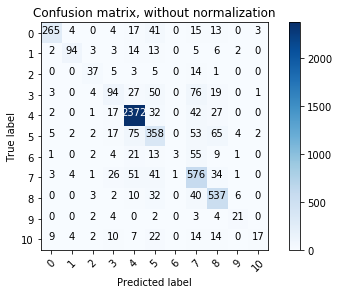

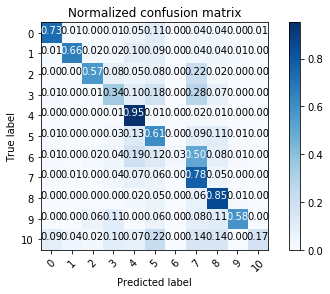

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[ 32   0   0   0   2   2   0   2   3   0   0]
 [  0   2   2   1   7   3   0   1   0   0   0]
 [  0   0   1   2   0   0   0   5   0   0   0]
 [  0   0   1  11   5   1   0  10   3   0   0]
 [  2   6   0   2 211  21   0  31   5   0   0]
 [  1   0   1   2   9  22   0  19  10   0   1]
 [  0   0   0   2   3   1   0   7   0   0   0]
 [  0   0   0   5   6   4   0  65   3   0   0]
 [  0   0   0   0   3   9   0  21  36   2   0]
 [  0   0   0   0   0   1   0   1   1   1   0]
 [  0   0   1   1   4   0   0   4   0   2   0]]
Normalized confusion matrix
[[0.7804878  0.         0.         0.         0.04878049 0.04878049
  0.         0.04878049 0.07317073 0.         0.        ]
 [0.         0.125      0.125      0.0625     0.4375     0.1875
  0.         0.0625     0.         0.         0.        ]
 [0.         0.         0.125      0.25       0.         0.
  0.         0.625      0.         0.         0.        ]
 [0.         0.         0.

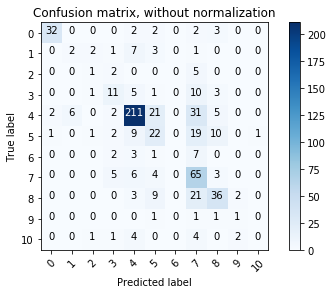

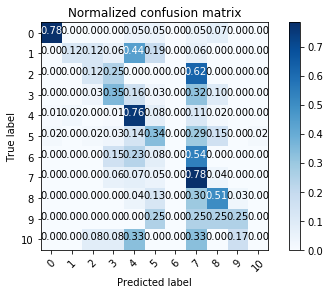

In [54]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_emb_train)
print_confusion_matrix(X_emb_train, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=CATEGORIES_COUNT)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_emb_test)
print_confusion_matrix(X_emb_test, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=CATEGORIES_COUNT)


In [55]:
print("Val accuracy: %.4f" % (test_scores[1]))

Val accuracy: 0.6125


In [56]:
%%time
train_predict = model.predict(X_emb_train)
test_predict = model.predict(X_emb_test)

file_path_train_X = "./LSTM_results_char_emb/USA_3rd_net_train_X_100_chars_GLOVE.FR.npy"
file_path_test_X = "./LSTM_results_char_emb/USA_3rd_net_test_X_100_chars_GLOVE.FR.npy"

np.save(file_path_train_X, train_predict)
np.save(file_path_test_X, test_predict)

Wall time: 28.9 s
